In [1]:
from PIL import Image
import os
import glob
import random
import csv
random.seed(4)
import json
import pandas as pd
import numpy as np
import tqdm
# Non propre A DELETE
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
# ENDELETE
import torch
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as transforms

from torchvision.utils import draw_bounding_boxes
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
import torch.nn.functional as func
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
import albumentations as A
## A nettoyer
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## En evaluation
import helpers.engine as eng # Needs debugging
from helpers.plotting import *
from helpers.ml_utils import *
#Temporary
import warnings
warnings.filterwarnings('ignore')

In [2]:
### DEFINITION DES FONCTIONS ###
def fastrcnn_loss_rebranded(class_logits, box_regression, labels, regression_targets):
    # type: (Tensor, Tensor, List[Tensor], List[Tensor]) -> Tuple[Tensor, Tensor]
    """
    Computes the loss for Faster R-CNN.
    Args:
        class_logits (Tensor)
        box_regression (Tensor)
        labels (list[BoxList])
        regression_targets (Tensor)
    Returns:
        classification_loss (Tensor)
        box_loss (Tensor)
    """

    labels = torch.cat(labels, dim=0)
    regression_targets = torch.cat(regression_targets, dim=0)

    classification_loss = func.cross_entropy(class_logits, labels,weight = AA_WEIGHTS_ZZ)

    # get indices that correspond to the regression targets for
    # the corresponding ground truth labels, to be used with
    # advanced indexing
    sampled_pos_inds_subset = torch.where(labels > 0)[0]
    labels_pos = labels[sampled_pos_inds_subset]
    N, num_classes = class_logits.shape
    box_regression = box_regression.reshape(N, box_regression.size(-1) // 4, 4)

    box_loss = func.smooth_l1_loss(
        box_regression[sampled_pos_inds_subset, labels_pos],
        regression_targets[sampled_pos_inds_subset],
        beta=1 / 9,
        reduction='sum',
    )
    box_loss = box_loss / labels.numel()

    return classification_loss, box_loss

In [3]:
### CONFIG ###

#model_path = "../saved_models/model3SGD"
path_to_data = '../dataset/dataset_Trashedy_1.2_augmented/train/'
path_to_validation_data = '../dataset/dataset_Trashedy_1.2_augmented/valid/'
model_save_name = "model_SGD_balanced_1.2_no_kebab"
device      = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cat_to_index = {'other': 1, 
                'pet': 2,   
                'plastic_bag' : 3
                }
num_classes = len(cat_to_index)+1
loss_value  = 0.0
num_epochs  = 8

In [4]:
### LOAD DATASET ###

tensor_transform = transforms.Compose([transforms.ToTensor()]) #,transforms.ColorJitter(brightness=0.15)

train_dataset = ObjectDetectionDataset(path_to_dataset = path_to_data,  
                                       transform = tensor_transform,
                                       mapping = cat_to_index,
                                       mode = 'train')

train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

validation_dataset = ObjectDetectionDataset(path_to_dataset = path_to_validation_data,  
                                       transform = tensor_transform,
                                       mapping = cat_to_index,
                                       mode = 'valid')

validation_data_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [5]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight('balanced', list(cat_to_index.keys()),validation_dataset.data['classes'].to_numpy())
class_weights = np.insert(class_weights, 0,np.mean(class_weights) ) #Inserting the weight for the background, BUT HOW TO CHOOSE IT ????
AA_WEIGHTS_ZZ = torch.from_numpy(class_weights)
AA_WEIGHTS_ZZ = AA_WEIGHTS_ZZ.to(torch.float32)
torchvision.models.detection.roi_heads.fastrcnn_loss = fastrcnn_loss_rebranded

In [6]:
### TELECHARGEMENT DU MODELE ###
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005) # IMPROVE WITH ADAM !
#optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

  0%|                                                                                          | 0/599 [00:00<?, ?it/s]


Training Loss : 0.11937


  0%|                                                                                          | 0/599 [00:00<?, ?it/s]


Training Loss : 0.08738


  0%|                                                                                          | 0/599 [00:00<?, ?it/s]


Training Loss : 0.12194


  0%|                                                                                          | 0/599 [00:00<?, ?it/s]


Training Loss : 0.06419


  0%|                                                                                          | 0/599 [00:00<?, ?it/s]


Training Loss : 0.06131


  0%|                                                                                          | 0/599 [00:00<?, ?it/s]


Training Loss : 0.05454


  0%|                                                                                          | 0/599 [00:00<?, ?it/s]


Training Loss : 0.04053


100%|████████████████████████████████████████████████████████████████████████████████| 599/599 [58:51<00:00,  5.90s/it]



Training Loss : 0.03651
Fin de l'entrainement, modele sauvegardé


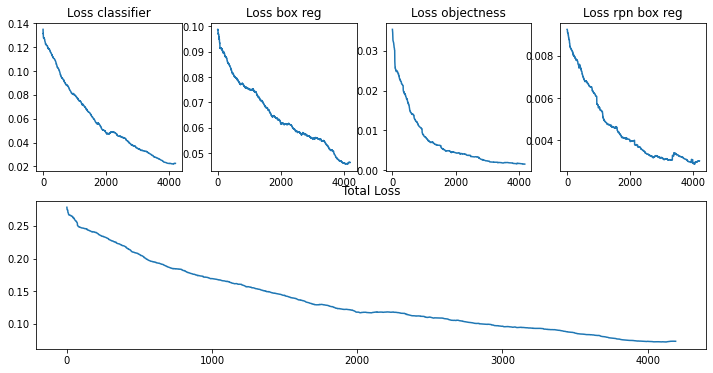

In [7]:
### ENTRAINEMENT DU MODELE ###

l_losses = {'loss_classifier' : [],'loss_box_reg' : [],'loss_rpn_box_reg' : [],'loss_objectness':[]}
for epoch in range(num_epochs):

    train_data_loader = tqdm.tqdm(train_data_loader)
    for images, targets, image_ids in train_data_loader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        l_losses['loss_classifier'].append(loss_dict['loss_classifier'].item())
        l_losses['loss_box_reg'].append(loss_dict['loss_box_reg'].item())
        l_losses['loss_objectness'].append(loss_dict['loss_objectness'].item())
        l_losses['loss_rpn_box_reg'].append(loss_dict['loss_rpn_box_reg'].item())
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
    print('\nTraining Loss : {:.5f}'.format(loss_value))
    #eng.evaluate(model, validation_data_loader, device=device)

## sauvegarde du modele et de ses performances


print("Fin de l'entrainement, modele sauvegardé")

plot_loss_summary(l_losses,train_dataset.__len__(),num_epochs)

In [8]:
os.mkdir("../saved_models/" + model_save_name)
torch.save(model,"../saved_models/" + model_save_name + "/" + model_save_name)

with open('../saved_models/'+ model_save_name +'.json', 'w') as f:
    json.dump(l_losses, f)
##